In [2]:
%matplotlib inline
import collections
import dask
import gcsfs
import h5py
import io
import matplotlib.pyplot as plt
import numba
import numpy as np
import os
import os.path
import pandas as pd
import pickle
import requests

from dask.distributed import Client
from dask_kubernetes import KubeCluster
from numba.typed import Dict

In [3]:
with open('../.gcs_tokens', 'rb') as f:
    credentials = pickle.load(f)
credentials = credentials[list(credentials.keys())[0]]
fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
fs.ls('l4dense/segmentation-volume')[:10]

['l4dense/segmentation-volume/x2y1z0.hdf5',
 'l4dense/segmentation-volume/x0y7z1.hdf5',
 'l4dense/segmentation-volume/x2y2z2.hdf5',
 'l4dense/segmentation-volume/x3y7z1.hdf5',
 'l4dense/segmentation-volume/x5y4z3.hdf5',
 'l4dense/segmentation-volume/x1y8z1.hdf5',
 'l4dense/segmentation-volume/x5y8z2.hdf5',
 'l4dense/segmentation-volume/x4y5z0.hdf5',
 'l4dense/segmentation-volume/x3y5z3.hdf5',
 'l4dense/segmentation-volume/x1y8z2.hdf5']

In [17]:
def download(filename):
    url = f"https://l4dense2019.brain.mpg.de/webdav/{filename}"
    result = requests.get(url, verify=False)
    result.raise_for_status()
    return result.content

def upload(filename, data, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'l4dense/{filename}', 'wb') as f:
        num_bytes = f.write(data)
    return num_bytes

def mirror(filename):
    print(f"Fetching {filename}")
    data = download(filename)
    num_bytes = upload(filename, data, credentials)
    return num_bytes


def locally_cache(filename, credentials):
    fs = gcsfs.GCSFileSystem(project='neuron-jungle', token=credentials)
    with fs.open(f'l4dense/{filename}', 'rb') as f:
        data = f.read()
    with open(f'../cache/{filename}', 'wb') as f:
        f.write(data)
    return len(data)

#mirror('axons.hdf5')
#locally_cache('dendrites.hdf5', credentials)
#locally_cache('axons.hdf5', credentials)
locally_cache('connectome.csv', credentials)
locally_cache('synapses.hdf5', credentials)

317257066

In [6]:
df = pd.read_csv('../cache/connectome.csv')

In [16]:
import collections
collections.Counter(list(df.columns.str[:4]))

Counter({'Unna': 1,
         'Soma': 80,
         'Prox': 89,
         'Smoo': 246,
         'Apic': 169,
         'Axon': 116,
         'Othe': 3019})

In [4]:
synapses = h5py.File('../cache/synapses.hdf5', 'r')
axons = h5py.File('../cache/axons.hdf5', 'r')
dendrites = h5py.File('../cache/dendrites.hdf5', 'r')
segments = h5py.File('../cache/segments.hdf5', 'r')
seg_positions = np.array(segments['segments']['position'])

In [17]:
pre_axon = np.array(synapses['synapses']['preAxonId'])
post_dendrite = np.array(synapses['synapses']['postDendriteId'])
positions = np.array(synapses['synapses']['position'])
pre_axon.max()
post_dendrite.max()

11399

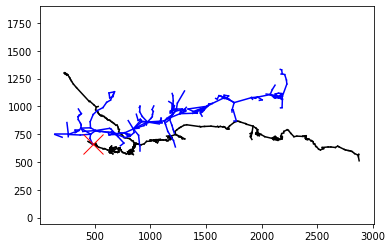

In [6]:
# Plot the skeletons for one pair
idx = 15
pre, post, pos = pre_axon[idx], post_dendrite[idx], positions[:, idx]
if pre == 0 or post == 0:
    print("Equal to 0, skipping")
else:
    edges = np.array(axons['axons']['skeleton'][str(pre)]['edges']) - 1
    nodes = np.array(axons['axons']['skeleton'][str(pre)]['nodes'])
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    plt.plot(connected_nodes[[0, 3], :], connected_nodes[[2, 5], :]*2.49, 'k-')

    edges = np.array(dendrites['dendrites']['skeleton'][str(post)]['edges']) - 1
    nodes = np.array(dendrites['dendrites']['skeleton'][str(post)]['nodes'])
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    _ = plt.plot(connected_nodes[[0, 3], :], connected_nodes[[2, 5], :]*2.49, 'b-')
    
    plt.plot(pos[0], pos[2]*2.49, 'rx', markerSize=20)
    plt.axis('equal')
#dendrite_segments = 
#dendrite_centers = seg_positions[:, np.array(dendrite_segments[idx])-1]


In [7]:
def get_neuron_map(dendrites):
    # Build a map from agglomerate ID to neuron id
    # First for dendrites
    agg_ids = list(dendrites['dendrites']['agglomerate'])
    neuron_ids = list(dendrites['dendrites']['neuronId'])
    agg_to_neuron_id = {k: neuron_ids[int(k) - 1] for k in agg_ids}

    neuron_segments = collections.defaultdict(lambda: [])
    neuron_agg = collections.defaultdict(lambda: [])
    for agg in list(dendrites['dendrites']['agglomerate'].keys()):
        if agg in agg_to_neuron_id and agg_to_neuron_id[agg] > 0:
            neuron_id = agg_to_neuron_id[agg]
            neuron_segments[neuron_id] += list(dendrites['dendrites']['agglomerate'][agg])
            neuron_agg[neuron_id].append(agg)

    # Add the axons, if available.
    dendrites_classes = np.array(dendrites['dendrites']['class'])

    neuron_map = {}
    for neuron_id, segment_ids in neuron_segments.items():
        for segment_id in segment_ids:
            neuron_map[segment_id] = neuron_id
    return neuron_segments, neuron_map, neuron_agg

dendrite_segments, dendrite_map, dendrite_agg = get_neuron_map(dendrites)

In [210]:
def get_neuron_map_with_axons(dendrites, axons):
    neurons = 0
    neurons_with_ais = 0
    neurons_with_axons = 0
    
    agg_ids = list(dendrites['dendrites']['agglomerate'])
    neuron_ids = list(dendrites['dendrites']['neuronId'])
    agg_to_neuron_id = {k: neuron_ids[int(k) - 1] for k in agg_ids}

    neuron_segments = collections.defaultdict(lambda: [])
    neuron_agg = collections.defaultdict(lambda: [])
    dendrite_classes = np.array(dendrites['dendrites']['class'])
    
    unique_neuron_ids = np.unique(neuron_ids)
    assert unique_neuron_ids[0] == 0
    unique_neuron_ids = unique_neuron_ids[1:]
    
    for neuron_id in unique_neuron_ids:
        print(f"Neuron {neuron_id}")
        neurons += 1
        
        # Find the AIS for this "dendrite"
        ais_agg = [k for k, v in agg_to_neuron_id.items() if v == neuron_id and dendrite_classes[int(k) - 1] == 2]

        if ais_agg:
            assert len(ais_agg) == 1
            neurons_with_ais += 1
            ais_segments = np.array(dendrites['dendrites']['skeleton'][ais_agg[0]]['segIds'])
            ais_segments = np.unique(ais_segments[ais_segments > 0])

            # Find an axon whose segments overlap this AIS.
            found_agg = False
            for i, agglomerate in enumerate(axons['axons']['skeleton'].keys()):
                probe = np.unique(np.array(axons['axons']['skeleton'][agglomerate]['segIds']))
                if len(ais_segments) + len(probe) > len(np.unique(np.concatenate((ais_segments, probe)))):
                    print("Found axon")
                    print(len(list(axons['axons']['agglomerate'][agglomerate])))
                    neurons_with_axons += 1
                    found_agg = True
                    neuron_segments[neuron_id] += list(axons['axons']['agglomerate'][agglomerate])
                    neuron_agg[neuron_id].append(agglomerate)
                    
    neuron_map_with_axons = {}
    for neuron_id, segment_ids in neuron_segments.items():
        for segment_id in segment_ids:
            neuron_map_with_axons[segment_id] = neuron_id
    return neuron_segments, neuron_map_with_axons, neuron_agg

axon_segments, axon_map, axon_agg = get_neuron_map_with_axons(dendrites, axons)

Neuron 1
Found axon
367
Neuron 2
Neuron 3
Found axon
1
Neuron 4
Found axon
57
Neuron 5
Neuron 6
Neuron 7
Found axon
547
Neuron 8
Found axon
36
Neuron 9
Neuron 10
Found axon
74
Neuron 11
Neuron 12
Neuron 13
Found axon
27
Neuron 14
Found axon
61
Neuron 15
Neuron 16
Neuron 17
Neuron 18
Neuron 19
Found axon
72
Neuron 20
Found axon
153
Neuron 21
Found axon
696
Neuron 22
Found axon
1727
Neuron 23
Neuron 24
Neuron 25
Found axon
797
Neuron 26
Neuron 27
Found axon
153
Neuron 28
Neuron 29
Found axon
325
Found axon
40
Neuron 30
Found axon
250
Neuron 31
Found axon
84
Neuron 32
Found axon
25
Found axon
426
Neuron 33
Neuron 34
Neuron 35
Neuron 36
Neuron 37
Neuron 38
Found axon
7
Neuron 39
Found axon
3141
Neuron 40
Found axon
328
Neuron 41
Neuron 42
Found axon
8
Found axon
20
Found axon
2
Neuron 43
Found axon
69
Neuron 44
Neuron 45
Neuron 46
Neuron 47
Neuron 48
Neuron 49
Found axon
145
Found axon
353
Neuron 50
Neuron 51
Found axon
3325
Neuron 52
Found axon
8
Neuron 53
Found axon
340
Neuron 54
Found a

In [211]:
# Find all existing synapses between axons (pre) and dendrites (post)
synapse_type = np.array(synapses['synapses']['type'])
pairs = zip(pre_axon, post_dendrite)
extant_pairs = {p: (synapse_num, v) for p, v, synapse_num in zip(pairs, synapse_type, np.arange(len(synapse_type)))}
pairs = collections.defaultdict(lambda: [])
for neuron_num_post, dendrite_aggs in dendrite_agg.items():
    for d_agg in dendrite_aggs:
        for neuron_num_pre, axon_aggs in axon_agg.items():
            for a_agg in axon_aggs:
                probe = (int(a_agg), int(d_agg))
                if probe in extant_pairs:
                    # Whoop! found a valid pair.
                    pairs[probe].append(extant_pairs[probe])
pairs

defaultdict(<function __main__.<lambda>()>,
            {(33691, 11208): [(146264, 2)],
             (33693, 11208): [(69420, 2)],
             (291, 11208): [(357438, 3)],
             (291, 11212): [(332458, 1)],
             (114, 11215): [(323852, 1)],
             (33692, 11215): [(363117, 1)],
             (2616, 11217): [(241531, 1)],
             (33692, 11217): [(364889, 1)],
             (5458, 11217): [(225167, 2)],
             (114, 11355): [(262498, 4)],
             (16980, 11220): [(209701, 1)],
             (33693, 11220): [(150195, 1)],
             (33692, 11221): [(308343, 3)],
             (114, 11226): [(349272, 3)],
             (12392, 11226): [(202911, 2)],
             (754, 11226): [(169261, 3)],
             (291, 11226): [(323827, 1)],
             (291, 11386): [(326531, 4)],
             (982, 11227): [(181165, 3)],
             (754, 11227): [(169651, 1)],
             (1191, 11227): [(217157, 1)],
             (291, 11228): [(329458, 1)],
             (

In [243]:
axons['axons']['class'][1]

1

postsynaptic,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
presynaptic,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


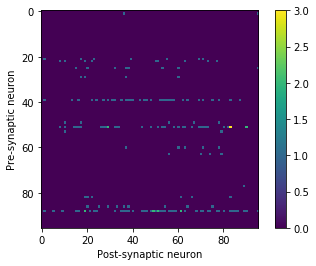

In [256]:
# Compute the connectome
connections = np.zeros((96, 96))
for pre, post in pairs.keys():
    neuron_pre  = [k for k, v in axon_agg.items() if str(pre) in v][0]
    neuron_post = [k for k, v in dendrite_agg.items() if str(post) in v][0]
    
    axon_type = axons['axons']['class'][pre - 1]
    if axon_type == 3:
        the_sign = -1
    elif axon_type == 4:
        the_sign = 0
    else:
        the_sign = 1
    
    connections[neuron_pre, neuron_post] += the_sign #print((neuron_pre, nyeuron_post))
#axon_segments[33691]
#axon_map[33691]
plt.imshow(connections)
plt.ylabel('Pre-synaptic neuron')
plt.xlabel('Post-synaptic neuron')
plt.colorbar()

df = pd.DataFrame(connections)
df = df.rename_axis('presynaptic', axis=0).rename_axis('postsynaptic', axis=1)
df

In [259]:
df.to_pickle('connectome.pkl')

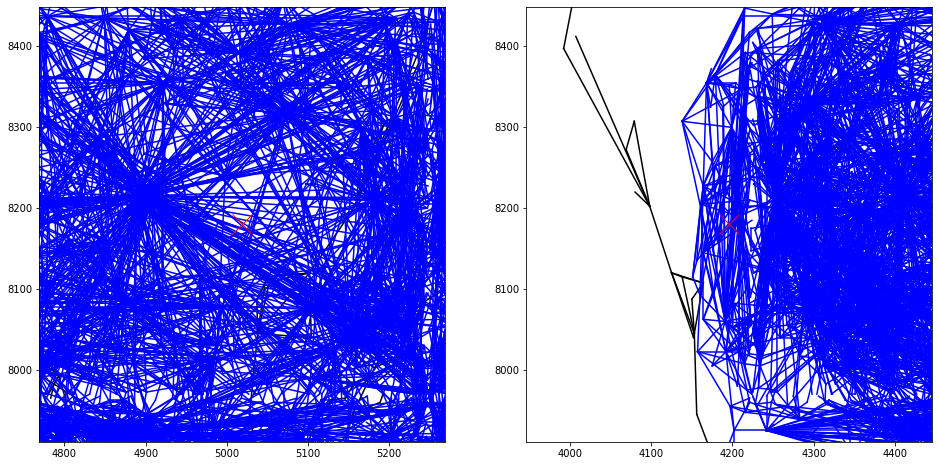

In [212]:
pre, post, synapse_id = 291, 11391, 361175
pos = positions[:, synapse_id]

plt.figure(figsize=(16, 8))

if pre == 0 or post == 0:
    print("Equal to 0, skipping")
else:
    edges = np.array(axons['axons']['skeleton'][str(pre)]['edges']) - 1
    nodes = np.array(axons['axons']['skeleton'][str(pre)]['nodes'])
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    
    plt.subplot(121)
    plt.plot(connected_nodes[[0, 3], :], connected_nodes[[2, 5], :]*2.49, 'k-')

    edges = np.array(dendrites['dendrites']['skeleton'][str(post)]['edges']) - 1
    nodes = np.array(dendrites['dendrites']['skeleton'][str(post)]['nodes'])
    
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    _ = plt.plot(connected_nodes[[0, 3], :], connected_nodes[[2, 5], :]*2.49, 'b-')
    
    plt.plot(pos[0], pos[2]*2.49, 'rx', markerSize=20)
    plt.axis('equal')
    xl = (pos[0] - 250, pos[0] + 250)
    yl = (pos[2]*2.49 - 250, pos[2]*2.49 + 250)
    plt.xlim(xl)
    plt.ylim(yl)
    
    
    edges = np.array(axons['axons']['skeleton'][str(pre)]['edges']) - 1
    nodes = np.array(axons['axons']['skeleton'][str(pre)]['nodes'])
    
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    plt.subplot(122)
    _ = plt.plot(connected_nodes[[1, 4], :], connected_nodes[[2, 5], :]*2.49, 'k-')

    edges = np.array(dendrites['dendrites']['skeleton'][str(post)]['edges']) - 1
    nodes = np.array(dendrites['dendrites']['skeleton'][str(post)]['nodes'])
    
    connected_nodes = np.concatenate((nodes[:, edges[0, :]], nodes[:, edges[1, :]]), axis=0)
    _ = plt.plot(connected_nodes[[1, 4], :], connected_nodes[[2, 5], :]*2.49, 'b-')
    plt.plot(pos[1], pos[2]*2.49, 'rx', markerSize=20)
    plt.axis('equal')
    xl = (pos[1] - 250, pos[1] + 250)
    yl = (pos[2]*2.49 - 250, pos[2]*2.49 + 250)
    plt.xlim(xl)
    plt.ylim(yl)

In [201]:
synapse_id = 9
pre_segment_ids = synapses['synapses']['preSegIds'][str(synapse_id + 1)]
post_segment_ids = synapses['synapses']['postSegIds'][str(synapse_id + 1)]
pre_pos = seg_positions[:, np.array(pre_segment_ids) - 1]
post_pos = seg_positions[:, np.array(post_segment_ids) - 1]

pre_voxel = segments['segments']['voxelCount'][np.array(pre_segment_ids) - 1]
post_voxel = segments['segments']['voxelCount'][np.array(post_segment_ids) - 1]

print((pre_pos).T)
print(positions[:, synapse_id])
print((post_pos).T)
#print((pre_voxel * pre_pos + post_voxel * post_pos) / (pre_voxel + post_voxel))
#post_voxel

[[578 651 256]]
[578 668 257]
[[596 653 249]]


In [206]:
np.array(pre_segment_ids)

array([86581], dtype=uint32)

In [131]:
positions[:, 0]
np.where(np.all(seg_positions == positions[:, 4].reshape((-1, 1)), axis=0))

(array([], dtype=int64),)